In [1]:
using Printf

# Scalar Contraction Mapping

In [2]:
# Simple fixed-point iteration for a contraction g on ℝ.
# Returns the fixed point, number of iterations, and the error history.

function fixed_point(g, x0; tol=1e-10, maxiter=10000)
    x = x0
    hist_x = Float64[]
    hist_error = Float64[]
    for k in 1:maxiter
        xnew = g(x)
        push!(hist_x, xnew)
        push!(hist_error, abs(xnew - x))
        if hist_error[end] < tol
            return (xnew, k, hist_x, hist_error)
        end
        x = xnew
    end
    return (x, maxiter, hist_x, hist_error)
end

fixed_point (generic function with 1 method)

In [3]:
# Example contraction: g(x) = a + q*x with |q|<1. Here q = 0.3, a = 0.5.

g(x) = 0.5 + 0.3*x
xstar_theory = 0.5 / (1 - 0.3)

0.7142857142857143

In [4]:
for x0 in (-10.0, 0.0, 2.0, 100.0)
    xstar, iters, hist_x, hist_error = fixed_point(g, x0; tol=1e-12)
    @printf "Start x0=%6.1f -> x* ≈ %.12f (theory %.12f) in %d iters; last |Δ|=%.2e\n" x0 xstar xstar_theory iters last(hist_error)
end
println()

Start x0= -10.0 -> x* ≈ 0.714285714285 (theory 0.714285714286) in 26 iters; last |Δ|=6.35e-13
Start x0=   0.0 -> x* ≈ 0.714285714286 (theory 0.714285714286) in 24 iters; last |Δ|=4.71e-13
Start x0=   2.0 -> x* ≈ 0.714285714286 (theory 0.714285714286) in 24 iters; last |Δ|=8.47e-13
Start x0= 100.0 -> x* ≈ 0.714285714286 (theory 0.714285714286) in 28 iters; last |Δ|=5.30e-13



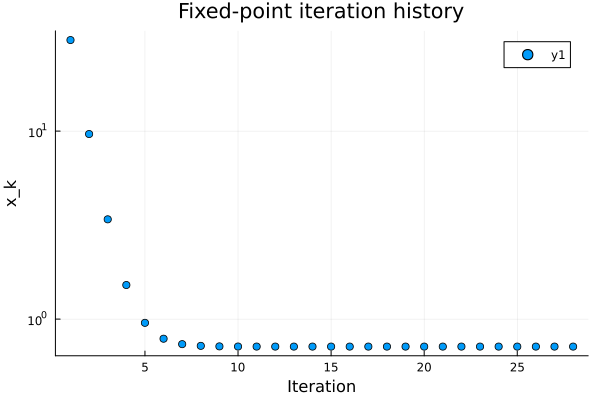

In [5]:
# Scatter Plot value history for one run
using Plots
x0 = 100.0
xstar, iters, hist_x, hist_error = fixed_point(g, x0; tol=1e-12)
scatter(1:iters, hist_x, yscale=:log10, xlabel="Iteration", ylabel="x_k", title="Fixed-point iteration history", lw=2, marker=:circle)

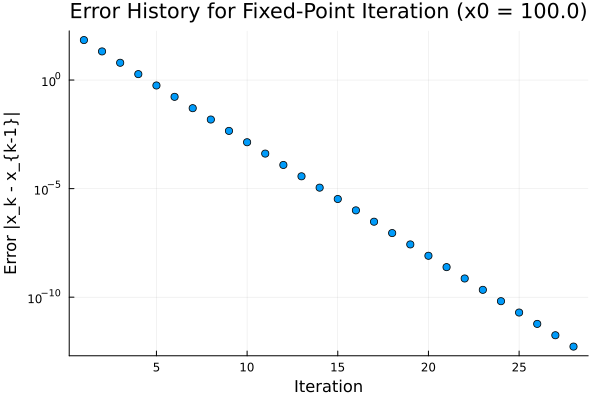

In [6]:
# Scatter Plot error history for one run
scatter(1:iters, hist_error, yscale=:log10, xlabel="Iteration", ylabel="Error |x_k - x_{k-1}|",
    title="Error History for Fixed-Point Iteration (x0 = $x0)", legend=false)

# Value Function Contraction Mapping

In [7]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, Parameters, Random
using Optim
using Printf
using Plots

#= =============================================================================
# Cake-Eating Problem (no interest, no income)
#   State: W_t (cake/wealth today)
#   Control: c_t ∈ [0, W_t]
#   Law of motion: W_{t+1} = W_t - c_t
#   Preferences: ∑ β^t log(c_t)
#   Bellman: V(W) = max_c { log(c) + β V(W - c) }
# T operator is a β-contraction in sup norm.
============================================================================= =#

#= =============================================================================
# Parameters
============================================================================= =#
β = 0.95
Wmax = 1.0           # maximum cake size
na  = 150            # number of grid points for W

#= =============================================================================
# Utility function
============================================================================= =#
function utility(c)
    if c <= 0.0
        return -1.0e6               # big penalty for infeasible consumption
    else
        return log(c)
    end
end

utility (generic function with 1 method)

In [8]:
#= =============================================================================
# Defining grid / vectors for value function and policy function
============================================================================= =#
Wgrid = range(0.0, Wmax, length = na)

V_guess_grid     = zeros(na)
V_new_grid       = zeros(na)
c_pol_grid       = zeros(na)
Wprime_pol_grid  = zeros(na)

# Interpolation of value function (Gridded linear, extrapolated linearly)
V_guess_ftn = extrapolate(
    interpolate(tuple(Wgrid), V_guess_grid, Gridded(Linear())),
    Line()
)

#= =============================================================================
# Bellman T operator for cake-eating problem
#   Given a current value function V_guess_ftn and state W,
#   returns T V(W), optimal c(W), and W'(W).
============================================================================= =#
function bellman_T_operator(V_guess_ftn, W)
    income = W                  # no interest, no wage; resource is just W

    function objective_for_c(x)
        c = x                   # consumption choice
        W_next = income - c
        # Bellman objective
        return utility(c) + β * V_guess_ftn(W_next)
    end

    # 1D maximization over c ∈ [0, W]
    results = Optim.maximize(objective_for_c, 0.0, income)
    c_star  = Optim.maximizer(results)
    T_V     = Optim.maximum(results)
    Wprime  = income - c_star

    return T_V, c_star, Wprime
end


bellman_T_operator (generic function with 1 method)

Iteration   1, Distance (sup norm): 1.000000e+06 
Iteration 100, Distance (sup norm): 6.232136e+03 
Iteration 200, Distance (sup norm): 3.689754e+01 
Iteration 300, Distance (sup norm): 2.184530e-01 
Iteration 400, Distance (sup norm): 1.293357e-03 
Iteration 500, Distance (sup norm): 7.655472e-06 
Converged after 540 iterations. Final distance: 9.834766e-07


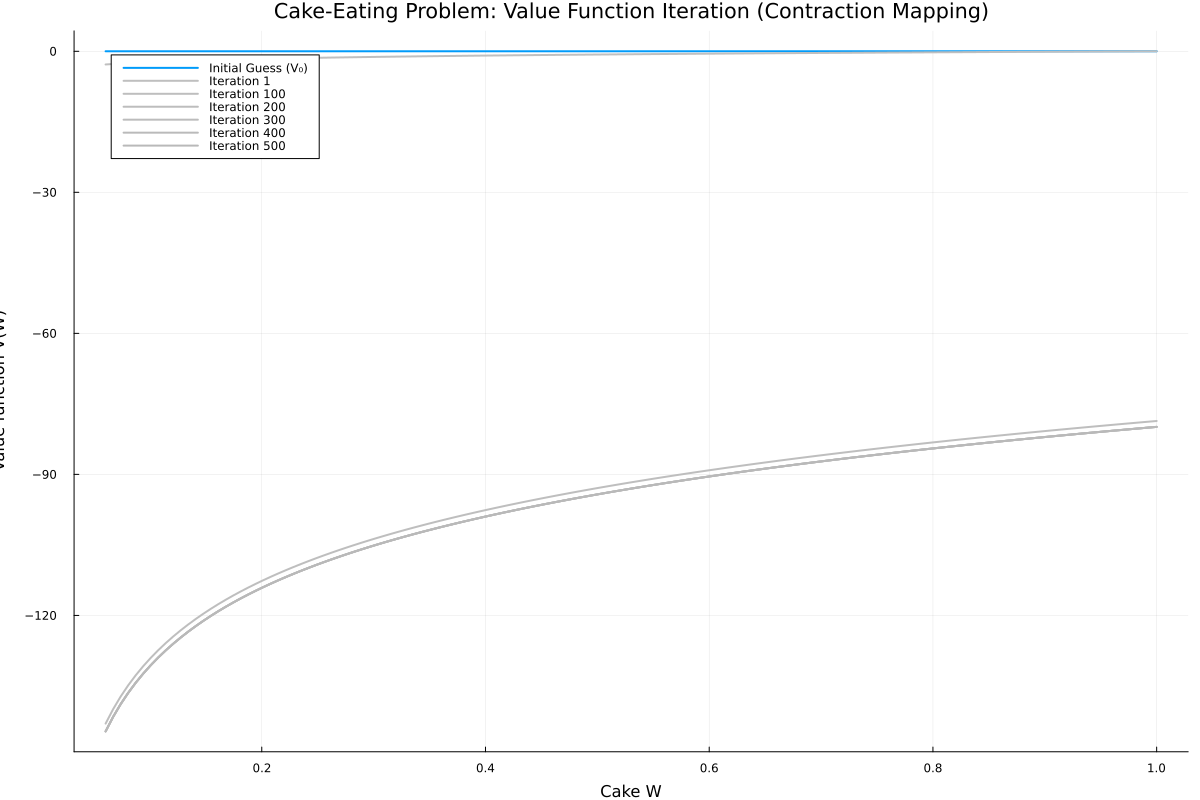

In [9]:
#= =============================================================================
# Value Function Iteration  
#   We repeatedly apply T to V, plotting V_k(W) every 10 iterations
#   to visualize the β-contraction.
============================================================================= =#

# Plotting initial guess
plt = plot(
    Wgrid[10:end], V_guess_grid[10:end],
    label = "Initial Guess (V₀)",
    lw = 2,
    size = (1200, 800)
)
plot!(plt, legend = :topleft)
xlabel!("Cake W")
ylabel!("Value function V(W)")
title!("Cake-Eating Problem: Value Function Iteration (Contraction Mapping)")

max_iter = 15000
tol      = 1e-6

for i_iter in 1:max_iter

    # Apply Bellman operator at each grid point
    for i_W in 1:na
        V_new_grid[i_W], c_pol_grid[i_W], Wprime_pol_grid[i_W] =
            bellman_T_operator(V_guess_ftn, Wgrid[i_W])
    end

    # Sup-norm distance (contraction metric)
    distance = maximum(abs.(V_new_grid .- V_guess_grid))

    # Plot V_k every 100 iterations to show convergence
    if i_iter % 100 == 0 || i_iter == 1
        shade = clamp(0.75 - 0.75 * (i_iter / max_iter), 0.0, 0.75)
        plot!(plt,
            Wgrid[10:end], V_new_grid[10:end],
            label = "Iteration $(i_iter)",
            color = RGB(shade, shade, shade),
            lw = 2
        )
        @printf("Iteration %3d, Distance (sup norm): %1.6e \n", i_iter, distance)
    end

    # Check convergence
    if distance < tol
        @printf("Converged after %d iterations. Final distance: %1.6e\n", i_iter, distance)
        # keep V_new_grid and policies as final
        V_guess_grid .= V_new_grid
        break
    else
        # Update guess and its interpolant
        V_guess_grid .= V_new_grid
        V_guess_ftn = extrapolate(
            interpolate(tuple(Wgrid), V_guess_grid, Gridded(Linear())),
            Line()
        )
    end
end

plot!(plt)   # finalize the plot
display(plt)